We first get necessary external data and code

In [1]:
# !git clone https://github.com/AllenInstitute/deepinterpolation.git
# !mkdir -p ephys

Install deepinterpolation package

In [2]:
# !pip install git+https://github.com/AllenInstitute/deepinterpolation.git

In [16]:
import deepinterpolation as de
import sys
from shutil import copyfile
import os
from deepinterpolation.generic import JsonSaver, ClassLoader
import datetime
from typing import Any, Dict
import pathlib
import sys

ERROR! Session/line number was not unique in database. History logging moved to new session 138


In [52]:
import spikeinterface as si
import numpy as np
import matplotlib.pyplot as plt

recording = si.BinaryRecordingExtractor(file_paths='../data/PAIRED_CRCNS_HC1/d11221/d1122101.dat',
                                        sampling_frequency=20000,
                                        num_chan=8,
                                        dtype=np.int16,
                                        time_axis=0)

In [53]:
recording.get_channel_ids()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [41]:
import matplotlib as mpl

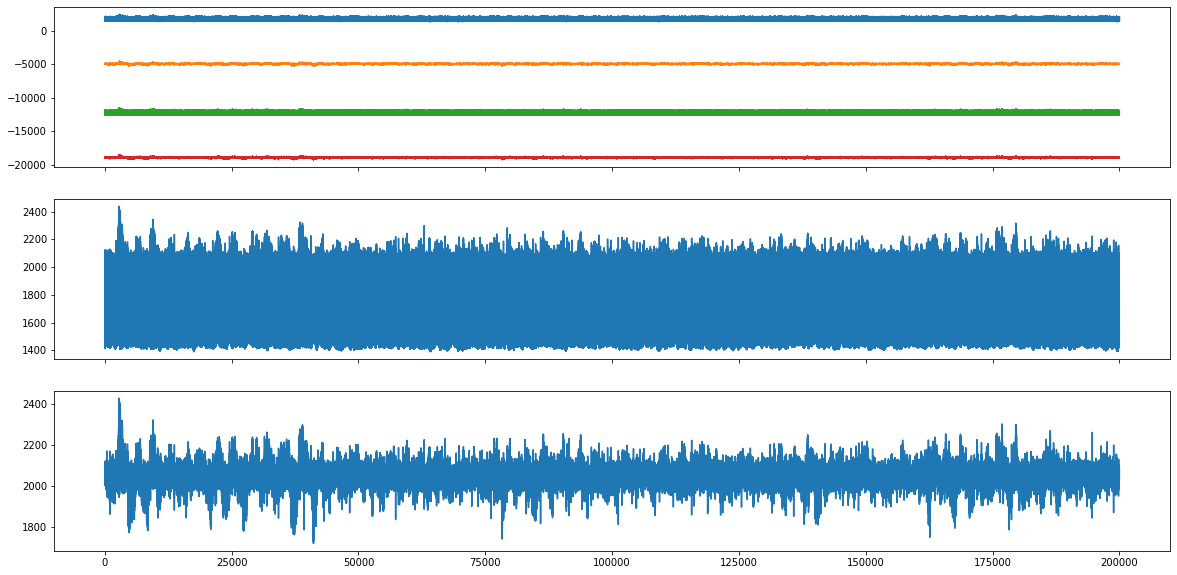

In [50]:
data = recording.get_traces()

t = 200000
fig, ax = plt.subplots(3, 1, figsize=(20,10), sharex=True)
for chan in range(4):
    ax[0].plot(data[:t, chan]-chan*7000)
ax[1].plot(data[:200000, 4])
ax[2].plot(data[:200000, 5])


In [20]:
recording.get_num_frames() / recording.get_sampling_frequency() 

375.0

This is used for record-keeping


In [6]:
now = datetime.datetime.now()
run_uid = now.strftime("%Y_%m_%d_%H_%M")

Initialize meta-parameters objects

In [7]:
training_param = {}
generator_param = {}
network_param = {}
generator_test_param = {}

An epoch is defined as the number of batches pulled from the dataset. Because our datasets are VERY large. Often, we cannot
go through the entirity of the data so we define an epoch slightly differently than is usual.

In [8]:
steps_per_epoch = 10

Those are parameters used for the Validation test generator. Here the test is done on the beginning of the data but
this can be a separate file

In [9]:
generator_test_param["type"] = "generator"  # type of collection
generator_test_param["name"] = "Paired_CRCNS_HC1_Generator"  # Name of object in the collection
generator_test_param[
    "pre_post_frame"
] = 32  # Number of frame provided before and after the predicted frame
generator_test_param["train_path"] = '/home/kyu/repos/deepinterpolation/data/PAIRED_CRCNS_HC1/d11221/d11221.001.dat'
generator_test_param["batch_size"] = 100
generator_test_param["start_frame"] = 1500000
generator_test_param["end_frame"] = 2250000
generator_test_param[
    "pre_post_omission"
] = 1  # Number of frame omitted before and after the predicted frame
generator_test_param["steps_per_epoch"] = -1  # No step necessary for testing as epochs are not relevant. -1 deactivate it.

Those are parameters used for the main data generator

In [10]:
generator_param["type"] = "generator"
generator_param["steps_per_epoch"] = steps_per_epoch
generator_param["name"] = "Paired_CRCNS_HC1_Generator"
generator_param["pre_post_frame"] = 32
generator_param["train_path"] = '/home/kyu/repos/deepinterpolation/data/PAIRED_CRCNS_HC1/d11221/d11221.001.dat'
generator_param["batch_size"] = 100
generator_param["start_frame"] = 2250000
generator_param["end_frame"] = -1
generator_param["pre_post_omission"] = 1

Those are parameters used for the network topology

In [11]:
network_param["type"] = "network"
network_param[
    "name"
] = "unet_tetrode2"  # Name of network topology in the collection

Those are parameters used for the training process

In [12]:
training_param["type"] = "trainer"
training_param["name"] = "core_trainer"
training_param["run_uid"] = run_uid
training_param["batch_size"] = generator_test_param["batch_size"]
training_param["steps_per_epoch"] = steps_per_epoch
training_param[
    "period_save"
] = 25  # network model is potentially saved during training between a regular nb epochs
training_param["nb_gpus"] = 0
training_param["apply_learning_decay"] = 0
training_param[
    "nb_times_through_data"
] = 1  # if you want to cycle through the entire data. Two many iterations will cause noise overfitting
training_param["learning_rate"] = 0.0001
training_param["pre_post_frame"] = generator_test_param["pre_post_frame"]
training_param["loss"] = "mean_absolute_error"
training_param[
    "nb_workers"
] = 1  # this is to enable multiple threads for data generator loading. Useful when this is slower than training

training_param["model_string"] = (
    network_param["name"]
    + "_"
    + training_param["loss"]
    + "_"
    + training_param["run_uid"]
)

Where do you store ongoing training progress

In [13]:
jobdir = os.path.join(
    "/home/kyu/repos/deepinterpolation/ephys", training_param["model_string"] + "_" + run_uid,
)
training_param["output_dir"] = jobdir

try:
    os.mkdir(jobdir)
except:
    print("folder already exists")

Here we create all json files that are fed to the training. This is used for recording purposes as well as input to the training proces

In [14]:
path_training = os.path.join(jobdir, "training.json")
json_obj = JsonSaver(training_param)
json_obj.save_json(path_training)

path_generator = os.path.join(jobdir, "generator.json")
json_obj = JsonSaver(generator_param)
json_obj.save_json(path_generator)

path_test_generator = os.path.join(jobdir, "test_generator.json")
json_obj = JsonSaver(generator_test_param)
json_obj.save_json(path_test_generator)

path_network = os.path.join(jobdir, "network.json")
json_obj = JsonSaver(network_param)
json_obj.save_json(path_network)

Here we create all objects for training.

In [15]:
# We find the generator obj in the collection using the json file
generator_obj = ClassLoader(path_generator)
generator_test_obj = ClassLoader(path_test_generator)

# We find the network obj in the collection using the json file
network_obj = ClassLoader(path_network)

# We find the training obj in the collection using the json file
trainer_obj = ClassLoader(path_training)

# We build the generators object. This will, among other things, calculate normalizing parameters.
train_generator = generator_obj.find_and_build()(path_generator)
test_generator = generator_test_obj.find_and_build()(path_test_generator)

# We build the network object. This will, among other things, calculate normalizing parameters.
network_callback = network_obj.find_and_build()(path_network)

# We build the training object.
training_class = trainer_obj.find_and_build()(train_generator, test_generator, network_callback, path_training)

input_img shape: (None, 64, 4, 1)
conv1 shape: (None, 64, 4, 64)
pool1 shape: (None, 16, 2, 64)
conv2 shape: (None, 16, 2, 128)
pool2 shape: (None, 4, 2, 128)


2021-08-13 16:19:13.241525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-13 16:19:13.297669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2021-08-13 16:19:13.298029: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-08-13 16:19:13.298116: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10'; dlerror: libcublas.so.10: cannot open shared object file: No such file or directory
2021-08-13 16:19:13.299898: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic li

Start training. This can take very long time.

In [15]:
training_class.run()

Epoch 1/5249
10/10 [==============================] - ETA: 0s - loss: 0.3895

Process Keras_worker_ForkPoolWorker-1:
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/connection.py", li

Traceback (most recent call last):
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_178923/2455323167.py", line 1, in <module>
    training_class.run()
  File "/home/kyu/repos/deepinterpolation/deepinterpolation/trainor_collection.py", line 234, in run
    self.model_train = self.local_model.fit(
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 862, in fit
    val_logs = self.evaluate(
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  Fi

Process Keras_worker_ForkPoolWorker-3:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = s

Traceback (most recent call last):
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_178923/2455323167.py", line 1, in <module>
    training_class.run()
  File "/home/kyu/repos/deepinterpolation/deepinterpolation/trainor_collection.py", line 234, in run
    self.model_train = self.local_model.fit(
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 862, in fit
    val_logs = self.evaluate(
  File "/home/kyu/miniconda3/envs/deepinterp/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  Fi

TypeError: object of type 'NoneType' has no len()

Finalize and save output of the training.

In [ ]:
training_class.finalize()

In [ ]:
import os
from deepinterpolation.generic import JsonSaver, ClassLoader
import pathlib

generator_param = {}
inferrence_param = {}

# We are reusing the data generator for training here. Some parameters like steps_per_epoch are irrelevant but currently needs to be provided
generator_param["type"] = "generator"
generator_param["name"] = "Paired_CRCNS_HC1_Generator"
generator_param["pre_post_frame"] = 32
generator_param["pre_post_omission"] = 1
generator_param[
    "steps_per_epoch"
] = -1  # No steps necessary for inference as epochs are not relevant. -1 deactivate it.

generator_param["train_path"] = '/home/kyu/repos/deepinterpolation/data/PAIRED_CRCNS_HC1/d11221/d11221.001.dat'

generator_param["batch_size"] = 100
generator_param["start_frame"] = 0
generator_param["end_frame"] = 1500000 #to go until the end.
generator_param[
    "randomize"
] = 0  # This is important to keep the order and avoid the randomization used during training


inferrence_param["type"] = "inferrence"
inferrence_param["name"] = "core_inferrence"

# Replace this path to where you stored your model
inferrence_param[
    "model_path"
] = "/Users/jeromel/Documents/Work documents/Allen Institute/Projects/Deep2P/repos/public/deepinterpolation_models/deep_interpolation_neuropixel_v1/2020_02_29_15_28_unet_single_ephys_1024_mean_squared_error-1050.h5"

# Replace this path to where you want to store your output file
inferrence_param[
    "output_file"
] = "/home/kyu/repos/deepinterpolation/tetrode_inference.h5"

jobdir = "/home/kyu/repos/deepinterpolation/test/"

try:
    os.mkdir(jobdir)
except:
    print("folder already exists")

path_generator = os.path.join(jobdir, "generator.json")
json_obj = JsonSaver(generator_param)
json_obj.save_json(path_generator)

path_infer = os.path.join(jobdir, "inferrence.json")
json_obj = JsonSaver(inferrence_param)
json_obj.save_json(path_infer)

generator_obj = ClassLoader(path_generator)
data_generator = generator_obj.find_and_build()(path_generator)

inferrence_obj = ClassLoader(path_infer)
inferrence_class = inferrence_obj.find_and_build()(path_infer, data_generator)

# Except this to be slow on a laptop without GPU. Inference needs parallelization to be effective.
inferrence_class.run()
